In [1]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

total_consumption_production = datastore.getTotalConsumptionProduction()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

transTo = datastore.getTransmissionCapTo()
transFrom = datastore.getTransmissionCapFrom()

# netFlow = datastore.getNetFlow() # Too many missing values
flow = datastore.getFlow()

capTo = datastore.getFlowCapacityTo()
capFrom = datastore.getFlowCapacityFrom()

exchangeFrom = datastore.getExchangeFrom()
exchangeTo = datastore.getExchangeTo() 

turnOver = datastore.getTurnover()

temp_pen = datastore.getDailyWeather() # DAILY celsius
wind_velocities = datastore.getHourlyWindVelocity() # m/s
hydroReservoirs = datastore.getWeeklyHydroReservs() # GWh

Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionGWh', 'ProductionGWh'], dtype='object') : 14
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 46
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 144
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 139
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 155
Missing values in Index(['TDK1SE3', 'TNO1SE3', 'TSE2SE3', 'TF1SE3', 'TSE4SE3'], dtype='object') : 0
Missing values in Index(['TSE3DK1', 'TSE3NO1', 'TSE3SE2', 'TSE3F1', 'TSE3SE4'], dtype='object') : 0
Missing values in Index(['F_LOWSE2SE3', 'F_LOWSE3FI', 'F_LOWSE3SE4'], dtype='object') : 6289
Missing values in Index(['C_SE4SE3', 'C_DK1SE3', 'C_FISE3', 'C_NO1SE3', 'C_SE2SE3'], 

In [8]:
import calendar_features as cf

dataset = pd.concat([spot, total_consumption_production,
                     production_se1_mwh, production_se2_mwh, production_se3_mwh, production_se4_mwh,  
                     flow, 
                     capTo, capFrom, exchangeFrom, exchangeTo,
                     turnOver, 
                     wind_velocities, hydroReservoirs, temp_pen, transTo, transFrom], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

# daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, holiday_features], axis=1)
dataset = pd.get_dummies(dataset, columns=["year", "month", "day_of_week", "hour"])


dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54024 entries, 2018-01-01 00:00:00 to 2024-02-29 23:00:00
Columns: 113 entries, spotPrice to hour_23
dtypes: float64(61), int32(1), int64(1), uint8(50)
memory usage: 30.8 MB


In [9]:
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'

test_split = '2024-02-23 23:00:00'
test_split_ = '2024-02-29 23:00:00'


train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)
test_split_future_covariates = dataset.index.get_loc(test_split_)

target = dataset['spotPrice'].to_frame()

past_covariates = dataset.iloc[:, 1:47]
future_covariates = dataset.iloc[:, 47:]
target_series = target

past_covariates = TimeSeries.from_dataframe(past_covariates)
future_covariates = TimeSeries.from_dataframe(future_covariates)
target_series = TimeSeries.from_dataframe(target_series)

past_covariates_train, past_covariates_val, past_covariates_test = past_covariates[:train_split_index], past_covariates[train_split_index:val_split_index], past_covariates[val_split_index:test_split_index]
future_covariates_train, future_covariates_val, future_covariates_test = future_covariates[:train_split_index], future_covariates[train_split_index:val_split_index], future_covariates[val_split_index:test_split_future_covariates]
target_train, target_val, target_test = target_series[:train_split_index], target_series[train_split_index:val_split_index], target_series[val_split_index:test_split_index]

past_covariates_scaler, future_covariates_scaler, target_scaler = Scaler(), Scaler(), Scaler()

past_covariates_train = past_covariates_scaler.fit_transform(past_covariates_train)
past_covariates_val = past_covariates_scaler.transform(past_covariates_val)
past_covariates_test = past_covariates_scaler.transform(past_covariates_test)

future_covariates_train = future_covariates_scaler.fit_transform(future_covariates_train)
future_covariates_val = future_covariates_scaler.transform(future_covariates_val)
future_covariates_test = future_covariates_scaler.transform(future_covariates_test)

target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

# past_covariates = concatenate([past_covariates_train, past_covariates_val, past_covariates_test])

past_covariates = concatenate([past_covariates_train, past_covariates_val, past_covariates_test])
future_covariates = concatenate([future_covariates_train, future_covariates_val, future_covariates_test])


In [10]:
from darts.models import TFTModel
from darts.utils.callbacks import TFMProgressBar
import torch
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


my_stopper = EarlyStopping(
    monitor="val_loss",
    patience= 10,
    min_delta = 0.01,
    mode='min',
)

# def generate_torch_kwargs():
#     # run torch models on CPU, and disable progress bars for all model stages except training.
#     return {
#         "pl_trainer_kwargs": {
#             "accelerator": 'auto',
#             "callbacks": [TFMProgressBar(enable_train_bar_only=True), my_stopper],
#         }
#     }

INPUT = 24 * 5 
OUTPUT = 24 * 5
EPOCHS = 2
HIDDEN_DIM = 64
LOSS_FN = torch.nn.L1Loss()
METRICS = SymmetricMeanAbsolutePercentageError()
BATCH_SIZE = 64
N_LAYERS = 2

DROPOUT = 0.3

tft = TFTModel(
    input_chunk_length = INPUT,
    output_chunk_length = OUTPUT,
    
    n_epochs = EPOCHS,
    hidden_size = HIDDEN_DIM,

    
    batch_size = BATCH_SIZE,
    dropout = DROPOUT,
    
    loss_fn = LOSS_FN,
    torch_metrics = METRICS
    
    ##**generate_torch_kwargs()
)


In [14]:
tft.fit(
    series = target_train,
    future_covariates = future_covariates_train,
    past_covariates = past_covariates_train,
    val_series = target_val,
    val_past_covariates = past_covariates_val,
    val_future_covariates = future_covariates_val,
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | L1Loss                           | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 265 K 
6  | decoder_vsn                       | _VariableSelectionNetwork        | 158 K 
7  | static_context_grn                | _GatedResidualNetwork            | 16.8 K
8  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K
9  | static_context_cell_encoder_grn  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\module.py:491: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\module.py:491: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.3, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=L1Loss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=120, output_chunk_length=120, n_epochs=2, batch_size=64, torch_metrics=SymmetricMeanAbsolutePercentageError())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE = 0.045208532738252705
SMAPE = 25.96711278060462
MAE = 0.03382885648391726


<Axes: xlabel='time'>

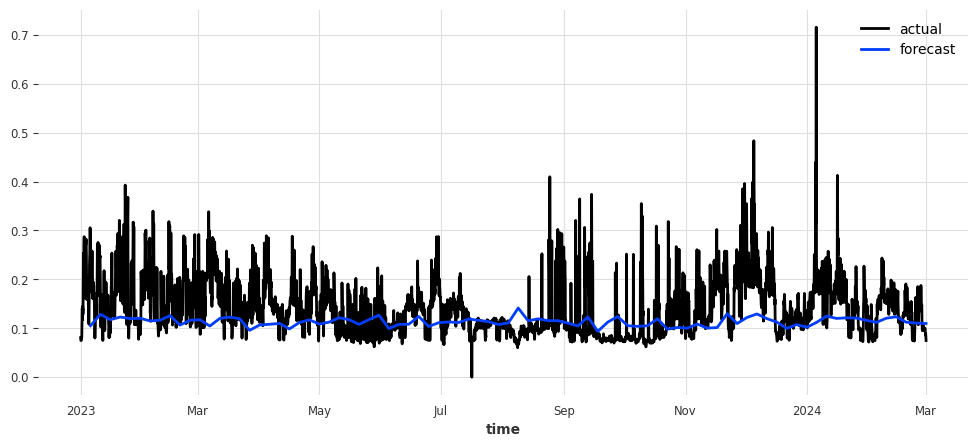

In [15]:
from darts.metrics import smape, mae, rmse

backtest = model.historical_forecasts(target_scaled,
                                      past_covariates = past_covariates,
                                      start = target_test.start_time(),
                                      forecast_horizon = OUTPUT,
                                      stride = OUTPUT,
                                      retrain = False,
                                      verbose = True)

backtest = concatenate(backtest)

print('RMSE = {}'.format(rmse(target_test, backtest)))
print('SMAPE = {}'.format(smape(target_test, backtest)))
print('MAE = {}'.format(mae(target_test, backtest)))


plt.figure(figsize=(12,5))
target_test.plot(label='actual')
backtest.plot(label='forecast')

In [17]:
pred = tft.predict(n = OUTPUT, series = target_test, past_covariates = past_covariates_test ,future_covariates = future_covariates_test, verbose = 1, mc_dropout=True, num_samples=100)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Date'>

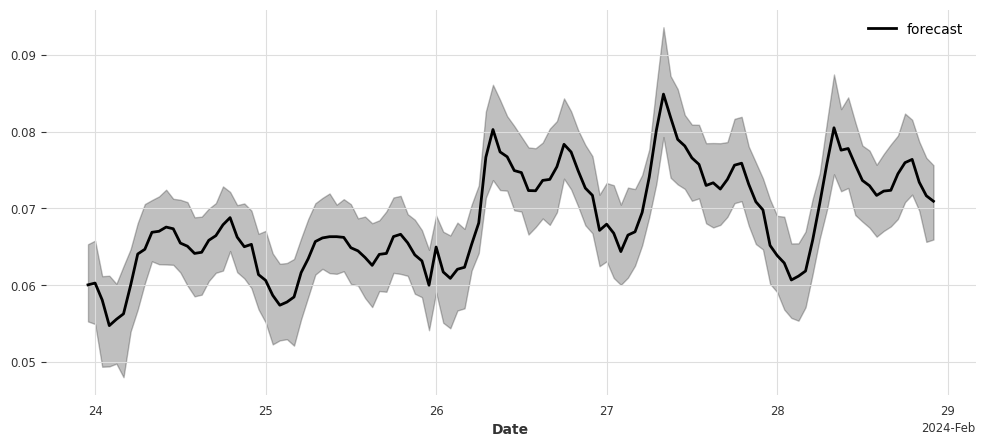

In [18]:
plt.figure(figsize=(12,5))

pred.plot(label='forecast')